In [183]:
import numpy as np 
import pandas as pd 
import re
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [184]:
col_names= ['JOBID', 'ACCOUNT', 'USER', 'REQMEM', 'USEDMEM', 'REQTIME', 'USEDTIME',
       'NODES', 'CPUS', 'PARTITION', 'EXITCODE', 'STATE', 'NODE1','NODE2','NODE3','NODE4']

accre_df = pd.read_csv('../data/accre-jobs-2020.csv', names=col_names) 
accre_df = accre_df.iloc[1:]

C:\Users\savro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,8,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [191]:
#delete
accre_df['NODES'].astype(int)
accre_df['NODES'].value_counts()

1      3778268
1        32637
2         2459
3          861
4          579
5          417
8          132
10         102
15          86
2           81
24          62
143         51
63          50
35          49
80          47
99          45
48          44
120         44
6           27
4           25
25          25
3           24
7           20
20          18
50          12
149          8
40           6
13           6
9            5
11           5
19           5
12           5
23           4
30           4
28           4
45           3
58           3
14           3
17           2
114          2
18           2
16           2
142          2
53           2
55           2
59           2
64           2
34           2
75           2
31           2
200          2
27           2
21           2
22           1
100          1
129          1
146          1
156          1
163          1
400          1
500          1
140          1
37           1
26           1
126          1
95           1
94        

In [192]:
accre_df[accre_df['NODES'] == 112]

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODE1,NODE2,NODE3,NODE4
1029694,18680401,crowns,tena,5120Mc,7076.92M,1-06:00:00,11:21:07,112,1,production,0:0,COMPLETED,cn[317-318,335-337,347-349,384-385


In [113]:
accre_df = pd.read_csv('../data/accre-jobs-2020.csv', error_bad_lines=False)

b'Skipping line 3461: expected 13 fields, saw 15\nSkipping line 3462: expected 13 fields, saw 16\nSkipping line 3465: expected 13 fields, saw 15\nSkipping line 3468: expected 13 fields, saw 16\nSkipping line 3472: expected 13 fields, saw 15\nSkipping line 3476: expected 13 fields, saw 16\nSkipping line 3479: expected 13 fields, saw 14\nSkipping line 3482: expected 13 fields, saw 14\nSkipping line 3486: expected 13 fields, saw 14\nSkipping line 3490: expected 13 fields, saw 14\nSkipping line 3494: expected 13 fields, saw 14\nSkipping line 3495: expected 13 fields, saw 16\nSkipping line 3497: expected 13 fields, saw 14\nSkipping line 3498: expected 13 fields, saw 14\nSkipping line 3499: expected 13 fields, saw 14\nSkipping line 3505: expected 13 fields, saw 14\nSkipping line 3517: expected 13 fields, saw 16\nSkipping line 3526: expected 13 fields, saw 15\nSkipping line 3528: expected 13 fields, saw 15\nSkipping line 3529: expected 13 fields, saw 15\nSkipping line 3530: expected 13 fields

b'Skipping line 268649: expected 13 fields, saw 16\nSkipping line 281380: expected 13 fields, saw 14\nSkipping line 283158: expected 13 fields, saw 48\nSkipping line 289776: expected 13 fields, saw 70\nSkipping line 290568: expected 13 fields, saw 15\nSkipping line 317525: expected 13 fields, saw 14\n'
b'Skipping line 329958: expected 13 fields, saw 14\nSkipping line 330461: expected 13 fields, saw 14\nSkipping line 332666: expected 13 fields, saw 15\nSkipping line 332762: expected 13 fields, saw 14\nSkipping line 332764: expected 13 fields, saw 14\nSkipping line 332766: expected 13 fields, saw 14\nSkipping line 332768: expected 13 fields, saw 14\nSkipping line 332769: expected 13 fields, saw 16\nSkipping line 332770: expected 13 fields, saw 14\nSkipping line 332898: expected 13 fields, saw 16\nSkipping line 332899: expected 13 fields, saw 14\nSkipping line 332900: expected 13 fields, saw 16\nSkipping line 332901: expected 13 fields, saw 14\nSkipping line 332902: expected 13 fields, sa

b'Skipping line 531726: expected 13 fields, saw 14\nSkipping line 543870: expected 13 fields, saw 14\nSkipping line 543903: expected 13 fields, saw 14\nSkipping line 544434: expected 13 fields, saw 14\nSkipping line 545969: expected 13 fields, saw 14\nSkipping line 546305: expected 13 fields, saw 43\nSkipping line 547218: expected 13 fields, saw 15\nSkipping line 547223: expected 13 fields, saw 56\nSkipping line 547224: expected 13 fields, saw 20\nSkipping line 547225: expected 13 fields, saw 22\nSkipping line 547226: expected 13 fields, saw 20\nSkipping line 547228: expected 13 fields, saw 19\nSkipping line 547230: expected 13 fields, saw 23\nSkipping line 547231: expected 13 fields, saw 25\nSkipping line 547233: expected 13 fields, saw 33\nSkipping line 547234: expected 13 fields, saw 53\nSkipping line 547245: expected 13 fields, saw 20\nSkipping line 547353: expected 13 fields, saw 14\nSkipping line 547359: expected 13 fields, saw 19\nSkipping line 547360: expected 13 fields, saw 21

b'Skipping line 660901: expected 13 fields, saw 15\nSkipping line 661332: expected 13 fields, saw 15\nSkipping line 662656: expected 13 fields, saw 14\nSkipping line 662863: expected 13 fields, saw 51\nSkipping line 662901: expected 13 fields, saw 15\nSkipping line 662902: expected 13 fields, saw 14\nSkipping line 662903: expected 13 fields, saw 14\nSkipping line 662904: expected 13 fields, saw 14\nSkipping line 662905: expected 13 fields, saw 14\nSkipping line 662906: expected 13 fields, saw 14\nSkipping line 662910: expected 13 fields, saw 14\nSkipping line 662914: expected 13 fields, saw 14\nSkipping line 662915: expected 13 fields, saw 15\nSkipping line 662916: expected 13 fields, saw 15\nSkipping line 662917: expected 13 fields, saw 15\nSkipping line 662918: expected 13 fields, saw 15\nSkipping line 662921: expected 13 fields, saw 15\nSkipping line 662922: expected 13 fields, saw 16\nSkipping line 662923: expected 13 fields, saw 19\nSkipping line 662924: expected 13 fields, saw 19

b'Skipping line 737407: expected 13 fields, saw 16\nSkipping line 753640: expected 13 fields, saw 14\nSkipping line 755322: expected 13 fields, saw 16\nSkipping line 773545: expected 13 fields, saw 15\nSkipping line 775580: expected 13 fields, saw 16\nSkipping line 775822: expected 13 fields, saw 56\nSkipping line 776044: expected 13 fields, saw 57\nSkipping line 776410: expected 13 fields, saw 16\nSkipping line 776465: expected 13 fields, saw 18\nSkipping line 777411: expected 13 fields, saw 14\nSkipping line 778897: expected 13 fields, saw 14\nSkipping line 778909: expected 13 fields, saw 14\nSkipping line 779030: expected 13 fields, saw 14\nSkipping line 779044: expected 13 fields, saw 14\nSkipping line 779162: expected 13 fields, saw 14\nSkipping line 783281: expected 13 fields, saw 14\nSkipping line 783282: expected 13 fields, saw 14\nSkipping line 783283: expected 13 fields, saw 14\nSkipping line 783284: expected 13 fields, saw 14\nSkipping line 783285: expected 13 fields, saw 14

b'Skipping line 919450: expected 14 fields, saw 16\nSkipping line 919451: expected 14 fields, saw 16\nSkipping line 919453: expected 14 fields, saw 15\nSkipping line 919454: expected 14 fields, saw 15\nSkipping line 919459: expected 14 fields, saw 16\nSkipping line 919462: expected 14 fields, saw 16\nSkipping line 919599: expected 14 fields, saw 16\nSkipping line 919601: expected 14 fields, saw 16\nSkipping line 936638: expected 14 fields, saw 16\nSkipping line 941490: expected 14 fields, saw 15\nSkipping line 941493: expected 14 fields, saw 15\nSkipping line 941494: expected 14 fields, saw 15\nSkipping line 941495: expected 14 fields, saw 16\nSkipping line 941496: expected 14 fields, saw 16\nSkipping line 941497: expected 14 fields, saw 16\nSkipping line 941499: expected 14 fields, saw 16\nSkipping line 941500: expected 14 fields, saw 16\nSkipping line 941501: expected 14 fields, saw 15\nSkipping line 941502: expected 14 fields, saw 16\nSkipping line 941509: expected 14 fields, saw 15

b'Skipping line 1921657: expected 14 fields, saw 17\nSkipping line 1922299: expected 14 fields, saw 19\nSkipping line 1922540: expected 14 fields, saw 22\nSkipping line 1922541: expected 14 fields, saw 15\nSkipping line 1922730: expected 14 fields, saw 22\nSkipping line 1922750: expected 14 fields, saw 21\nSkipping line 1922839: expected 14 fields, saw 20\nSkipping line 1922840: expected 14 fields, saw 21\nSkipping line 1922871: expected 14 fields, saw 19\nSkipping line 1938820: expected 14 fields, saw 21\nSkipping line 1938863: expected 14 fields, saw 21\nSkipping line 1938884: expected 14 fields, saw 20\nSkipping line 1939058: expected 14 fields, saw 20\nSkipping line 1939242: expected 14 fields, saw 38\nSkipping line 1949018: expected 14 fields, saw 22\nSkipping line 1949087: expected 14 fields, saw 24\n'
b'Skipping line 1973533: expected 14 fields, saw 15\nSkipping line 1978566: expected 14 fields, saw 17\nSkipping line 1979172: expected 14 fields, saw 16\nSkipping line 1980867: ex

b'Skipping line 2261236: expected 14 fields, saw 15\nSkipping line 2261237: expected 14 fields, saw 15\nSkipping line 2261238: expected 14 fields, saw 15\nSkipping line 2261244: expected 14 fields, saw 15\nSkipping line 2268336: expected 14 fields, saw 15\nSkipping line 2277496: expected 14 fields, saw 15\nSkipping line 2280917: expected 14 fields, saw 15\nSkipping line 2281022: expected 14 fields, saw 16\nSkipping line 2282606: expected 14 fields, saw 17\nSkipping line 2288483: expected 14 fields, saw 16\nSkipping line 2288537: expected 14 fields, saw 16\nSkipping line 2290814: expected 14 fields, saw 16\nSkipping line 2290957: expected 14 fields, saw 16\nSkipping line 2290958: expected 14 fields, saw 17\nSkipping line 2290959: expected 14 fields, saw 17\nSkipping line 2290961: expected 14 fields, saw 15\nSkipping line 2290962: expected 14 fields, saw 16\nSkipping line 2290963: expected 14 fields, saw 17\nSkipping line 2290966: expected 14 fields, saw 15\nSkipping line 2291056: expect

b'Skipping line 2393269: expected 14 fields, saw 45\nSkipping line 2393665: expected 14 fields, saw 16\nSkipping line 2393729: expected 14 fields, saw 16\nSkipping line 2393731: expected 14 fields, saw 16\nSkipping line 2393757: expected 14 fields, saw 16\nSkipping line 2393946: expected 14 fields, saw 15\nSkipping line 2403928: expected 14 fields, saw 15\nSkipping line 2403958: expected 14 fields, saw 15\nSkipping line 2409122: expected 14 fields, saw 77\nSkipping line 2409596: expected 14 fields, saw 16\nSkipping line 2420531: expected 14 fields, saw 41\nSkipping line 2420538: expected 14 fields, saw 46\nSkipping line 2420539: expected 14 fields, saw 70\nSkipping line 2420653: expected 14 fields, saw 46\nSkipping line 2420655: expected 14 fields, saw 67\nSkipping line 2420657: expected 14 fields, saw 89\n'
b'Skipping line 2442910: expected 14 fields, saw 35\nSkipping line 2442911: expected 14 fields, saw 41\nSkipping line 2442917: expected 14 fields, saw 66\nSkipping line 2448023: ex

In [114]:
#subsetting data for cms
cms_df = accre_df[accre_df['ACCOUNT']=='cms']
cms_df = cms_df[cms_df['PARTITION']!='debug']
cms_df = cms_df[(cms_df['USER']=='cmspilot')|(cms_df['USER']=='cmslocal')]

The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot".

For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes.

Do any of their jobs that ended in under an hour also cluster on specific compute nodes, 
suggesting possbily unreliable systems? 

Check both “production” and “nogpfs” partitions. 

Look for commonly failing nodes and compare with other failed jobs.

In [115]:
cms_df.shape

(699831, 13)

#Convertine time to seconds

for index, row in cms_df.USEDTIME.iteritems():
    total_seconds = 0
    chopped_row = row.split(":")
    minutes = int(chopped_row[1])
    seconds = int(chopped_row [2])
    
    if len(chopped_row[0]) > 2:
        days_hours = chopped_row[0].split('-')
        days = int(days_hours[0])
        hours = int(days_hours[1])
    else:
        day = 0
        hours = int(chopped_row[0])
    total_time = (days*86400) + (hours*3600) + (minutes*60) + (seconds)
    cms_df['USEDTIME'][index] = total_time

In [116]:
cms_df.head(1)

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST
2125,17032244,cms,cmspilot,28000Mn,8320.07M,2-00:00:00,1-23:31:46,1,4,production,0:0,COMPLETED,cn1205


In [117]:
#getting time under an hour
cms_df['under_hour'] = False

for index, row in cms_df.USEDTIME.iteritems():
    chopped_row = str(row).split(":")
    if chopped_row[0] == '00':
        cms_df['under_hour'][index] = True

C:\Users\savro\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [118]:
#subsetting for time under an hour
cms_df = cms_df[cms_df['under_hour'] == True]

In [119]:
cms_df['USEDTIME'].value_counts().tail(10)

00:55:55    4
00:55:36    4
00:11:22    3
00:11:54    3
00:59:44    3
00:55:56    3
00:57:59    3
00:46:41    3
00:53:20    2
00:55:58    1
Name: USEDTIME, dtype: int64

In [120]:
pd.crosstab(cms_df['EXITCODE'],cms_df['STATE']).apply(lambda x: (x/x.sum()), axis=1)

STATE,CANCELLED,CANCELLED by 9201,CANCELLED by 9202,COMPLETED,FAILED,RUNNING
EXITCODE,,,,,,
0:0,0.003442,0.000007,0.000007,0.996388,0.000000,0.000157
0:9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
127:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1:0,0.733333,0.000000,0.000000,0.000000,0.266667,0.000000


In [121]:
#getting only failed jobs
#using state != to complete instead of exit code beacuse its built in their code to crash and error might not be reflected in exit code
cms_failed = cms_df[cms_df['STATE'] != 'COMPLETED']
cms_completed = cms_df[cms_df['STATE'] == 'COMPLETED']
#cms_df = cms_df[cms_df['EXITCODE'] != '0:0']
cms_failed['STATE'].value_counts()

CANCELLED            1597
RUNNING                70
FAILED                 60
CANCELLED by 9202       3
CANCELLED by 9201       3
Name: STATE, dtype: int64

In [144]:
pd.crosstab(cms_failed['NODELIST'],cms_failed['EXITCODE']).apply(lambda x: (x/x.sum()), axis=1)

EXITCODE,0:0,0:9,126:0,127:0,1:0
NODELIST,,,,,
cn1081,1.000000,0.000000,0.000000,0.000000,0.000000
cn1083,1.000000,0.000000,0.000000,0.000000,0.000000
cn1084,1.000000,0.000000,0.000000,0.000000,0.000000
cn1085,1.000000,0.000000,0.000000,0.000000,0.000000
cn1086,1.000000,0.000000,0.000000,0.000000,0.000000
cn1088,1.000000,0.000000,0.000000,0.000000,0.000000
cn1089,1.000000,0.000000,0.000000,0.000000,0.000000
cn1090,1.000000,0.000000,0.000000,0.000000,0.000000
cn1091,1.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.crosstab(cms_df['EXITCODE'],cms_df['STATE']).apply(lambda x: (x/x.sum()), axis=1)

In [ ]:
#cleaning without for loop
#clean_accre_df['REQTIME'] = clean_accre_df['REQTIME'].replace('-',':',regex=True)


In [170]:
cms_failed['NODELIST'].value_counts().head(30)

ng518     16
cn1314    12
cn394     11
ng734     10
cn475      9
cn1094     9
ng1112     9
cn449      9
cn1121     9
cn304      9
cn1394     8
cn408      8
cn1387     8
cn399      8
cn363      8
cn429      8
cn1398     8
cn312      8
ng1033     7
cn1391     7
cn1379     7
cn1128     7
cn405      7
ng1010     7
cn306      7
cn494      7
cn1089     7
cn485      7
cn1435     7
cn1307     6
Name: NODELIST, dtype: int64

In [127]:
cms_completed['NODELIST'].value_counts().head(30)

ng518     19336
ng1078     6382
ng1112     6162
ng1040     5671
ng1027     5640
ng1003     5625
ng507      5394
ng1067     5351
ng909      5154
ng205      4689
ng502      4619
ng688      4574
ng1063     4551
ng1020     4547
ng514      4448
ng915      4363
ng678      4362
ng1036     4328
ng1080     4317
ng1014     4257
ng1061     4187
ng734      4128
ng1039     4013
ng733      3984
ng512      3603
ng1068     3482
ng739      3455
ng1079     3166
ng729      2542
ng1033     2504
Name: NODELIST, dtype: int64

In [165]:
d = cms_df[cms_df['NODELIST'] == 'cn1398']
d.shape

(550, 15)

In [178]:
CMS_nodes = {'NODE':['ng518','cn1314','cn394','ng734','cn475','cn1094','ng1112','cn449','cn1121','cn304','cn1394','cn408','cn1387','cn399','cn363','cn429','cn1398','cn312'],
            'TIMES_FAILED':[16,12,11,10,9,9,9,9,9,9,8,8,8,8,8,8,8,8],
            'TOTAL_TIMES_USED':[19352,12,347,4138,364,397,6171,400,465,298,408,446,249,415,339,306,550,407]}
CMS_nodes_df = pd.DataFrame(CMS_nodes, columns = ['NODE','TIMES_FAILED','TOTAL_TIMES_USED'])

In [179]:
CMS_nodes_df['PERCENT_FAILED'] = (CMS_nodes_df['TIMES_FAILED']/CMS_nodes_df['TOTAL_TIMES_USED'])*100
CMS_nodes_df.tail(10)

,NODE,TIMES_FAILED,TOTAL_TIMES_USED,PERCENT_FAILED
8,cn1121,9,465,1.935484
9,cn304,9,298,3.020134
10,cn1394,8,408,1.960784
11,cn408,8,446,1.793722
12,cn1387,8,249,3.212851
13,cn399,8,415,1.927711
14,cn363,8,339,2.359882
15,cn429,8,306,2.614379
16,cn1398,8,550,1.454545
17,cn312,8,407,1.965602


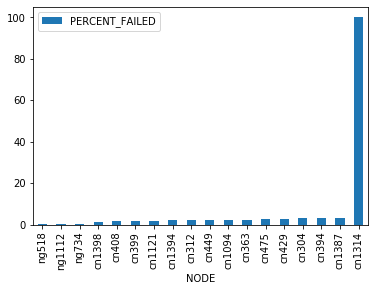

In [181]:
#plotted with one outlier, maybe remove it to make it easier to see
CMS_nodes_df.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED')

In [182]:
CMS_nodes_df.sort_values('PERCENT_FAILED')

,NODE,TIMES_FAILED,TOTAL_TIMES_USED,PERCENT_FAILED
0,ng518,16,19352,0.082679
6,ng1112,9,6171,0.145843
3,ng734,10,4138,0.241663
16,cn1398,8,550,1.454545
11,cn408,8,446,1.793722
13,cn399,8,415,1.927711
8,cn1121,9,465,1.935484
10,cn1394,8,408,1.960784
17,cn312,8,407,1.965602
7,cn449,9,400,2.250000


In [138]:
t = cms_df[cms_df['NODELIST']=='cn1094']
t.shape

(397, 14)

In [105]:
most_failed_nodes = cms_df['NODELIST'].value_counts().head(20)

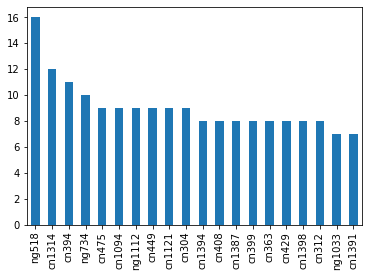

In [106]:
most_failed_nodes.plot(kind = 'bar')

In [107]:
# calculate percent failed
#number failed/ total times used in cms
cms_df['NODELIST'].value_counts()

ng518     16
cn1314    12
cn394     11
ng734     10
cn475      9
          ..
cn467      1
cn1580     1
cn1328     1
cn1266     1
cn1257     1
Name: NODELIST, Length: 614, dtype: int64

In [108]:
df_ng518 = accre_df[accre_df['NODELIST'] == 'cn475']
df_ng518['EXITCODE'].value_counts()

0:0    5083
0:9       1
Name: EXITCODE, dtype: int64

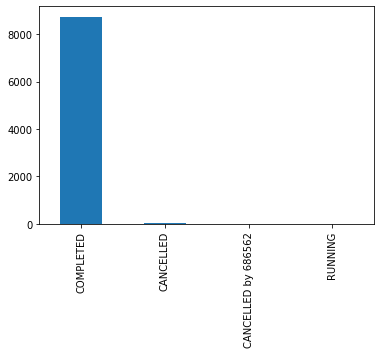

In [109]:
testing_cn1314 = accre_df[accre_df['NODELIST'] == 'cn1314']
testing_cn1314['STATE'].value_counts().plot(kind = 'bar')

In [ ]:
accre_df['NODES'] = accre_df['NODES'].astype(int)

In [ ]:
accre_df['CPUS'] = accre_df['CPUS'].astype(int)

In [ ]:
accre_df.dtypes

In [ ]:
exactly_2_nodes = accre_df[accre_df['NODES'] == 2]
exactly_2_nodes.shape

In [ ]:
# concatinating all nodes into the NODE1 column
for index, row in accre_df.NODE1.iteritems():
    node1 = str(accre_df['NODE1'][index])
    node2 = str(accre_df['NODE2'][index])
    node3 = str(accre_df['NODE3'][index])
    node4 = str(accre_df['NODE4'][index])
    
    accre_df['NODE2'][index] = ''
    accre_df['NODE3'][index] = ''
    accre_df['NODE4'][index] = ''
    
    node_row = node1 + ',' + node2 + ',' + node3 + ',' + node4
    node_row = node_row.split('nan')[0]
    accre_df['NODE1'][index] = node_row[:-1]
    
#dropping columns NODE2-NODE4
accre_df = accre_df.drop(['NODE2', 'NODE3', 'NODE4'], axis=1)

for index, row in accre_df.NODE1.iteritems():
    if accre_df['NODE4'][index] == accre_df['NODE4'][index]:
        node1 = accre_df['NODE1'][index] + ',' + str(accre_df['NODE2'][index]) + ',' + str(accre_df['NODE3'][index]) + ',' + str(accre_df['NODE4'][index])
    elif accre_df['NODE3'][index] == accre_df['NODE3'][index]:
        node1 = accre_df['NODE1'][index] + ',' + str(accre_df['NODE2'][index]) + ',' + str(accre_df['NODE3'][index])
    elif accre_df['NODE2'][index] == accre_df['NODE2'][index]:
        node1 = accre_df['NODE1'][index] + ',' + str(accre_df['NODE2'][index])
    else:
        node1 = accre_df['NODE1'][index]
    accre_df['NODE1'][index] = node1

#This fixes formatting for when NODES = 2, press 'esc'-'o' to hide pink warning
for index, row in accre_df.NODE1.iteritems():
    if accre_df.NODES[index] == 2:
        broken_node1 = row.split('[')

        if len(broken_node1[1]) < 5:
            accre_df['NODE1'][index] = broken_node1[0] + broken_node1[1]
            accre_df['NODE2'][index] = broken_node1[0] + accre_df['NODE2'][index][:-1]
            
        else:
            broken_node1[1] = broken_node1[1][:-1]
            two_num_split = broken_node1[1].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE2'][index] = broken_node1[0] + two_num_split[1]            

In [88]:
accre_df[accre_df['NODELIST'] == 'ngcn1314']

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST


#This fixes formatting for when NODES = 3, press 'esc'-'o' to hide pink warning
for index, row in accre_df.NODE1.iteritems():          
    if accre_df.NODES[index] == 3:
        
        broken_node1 = row.split('[')

        if accre_df['NODE3'][index] == accre_df['NODE3'][index]:
            accre_df['NODE1'][index] = broken_node1[0] + broken_node1[1]
            accre_df['NODE2'][index] = broken_node1[0] + accre_df['NODE2'][index]
            accre_df['NODE3'][index] = broken_node1[0] + accre_df['NODE3'][index][:-1]
                                                             
        elif accre_df['NODE2'][index] != accre_df['NODE2'][index]:
            broken_node1[1] = broken_node1[1][:-1]
            two_num_split = broken_node1[1].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE2'][index] = broken_node1[0] + str(int(two_num_split[0]) + 1)
            accre_df['NODE3'][index] = broken_node1[0] + two_num_split[1]
            
        elif len(broken_node1[1]) < 5:
            two_num_split = accre_df['NODE2'][index].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + broken_node1[1]
            accre_df['NODE2'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE3'][index] = broken_node1[0] + two_num_split[1][:-1]
            
        else:
            two_num_split = broken_node1[1].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE3'][index] = broken_node1[0] + accre_df['NODE2'][index][:-1]
            accre_df['NODE2'][index] = broken_node1[0] + two_num_split[1]

In [ ]:
accre_df[accre_df['NODES'] == 3]

In [ ]:
accre_df[accre_df['NODES'] == 2].head(10)

In [ ]:
#how to export clean data as a csv
#df.to_csv('path', index = False)